# Setup

In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1,6,7"

In [2]:
from pathlib import Path
import statistics

import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold

import catboost as cb
import optuna

In [3]:
AUTO_FIND_HYPERPARAMETERS = False
MANUAL_FIND_HYPERPARAMETERS = True
EVALUATE_ON_VAL = True

RANDOM_SEED = 42

TRAIN_DATA_PATH = Path('../metamodel/train-data/')
METAMODEL_PATH = Path('../metamodel/')

# Load data

In [4]:
X = pd.read_csv(TRAIN_DATA_PATH / 'data_X.csv', index_col='line_id')
y = pd.read_csv(TRAIN_DATA_PATH / 'data_y.csv', index_col='line_id')

display(X)
display(y)

,s_len,q_len,a_len,p(Contr)_ivankud-deberta-v2-xlarge-mnli,p(Entl)_ivankud-deberta-v2-xlarge-mnli,p(Contr)_ivankud-deberta-v3-large-tasksource-nli,p(Entl)_ivankud-deberta-v3-large-tasksource-nli,p(Contr)_ivankud-DeBERTa-v3-large-mnli-fever-anli-ling-wanli,p(Entl)_ivankud-DeBERTa-v3-large-mnli-fever-anli-ling-wanli
line_id,,,,,,,,,
0,254,70,13,0.997253,0.002425,0.995231,0.003330,0.999554,0.000191
1,293,48,18,0.056191,0.942184,0.015380,0.983818,0.004416,0.995197
2,119,31,8,0.998265,0.001616,0.998759,0.000613,0.999784,0.000111
3,392,23,5,0.998025,0.001826,0.998977,0.000590,0.999668,0.000289
4,384,14,162,0.998225,0.001599,0.998350,0.001113,0.999649,0.000311
...,...,...,...,...,...,...,...,...,...
1045,216,36,41,0.029893,0.968082,0.016454,0.982488,0.051092,0.947630
1046,534,65,16,0.998526,0.001298,0.998351,0.001386,0.998442,0.001362
1047,120,25,11,0.999248,0.000674,0.998958,0.000773,0.998919,0.000903


,is_hallucination
line_id,
0,1
1,0
2,1
3,1
4,1
...,...
1045,0
1046,1
1047,1


# Manual search hyperparameters

In [14]:
if MANUAL_FIND_HYPERPARAMETERS:
    # initialize Pool
    train_pool = cb.Pool(X, y['is_hallucination'])

    # Initialize CV
    params = {
        'learning_rate': 0.02,
        # 'depth': 4,
        # 'l2_leaf_reg': 0.4989834106858575,
        # 'leaf_estimation_iterations': 7,
        # 'bagging_temperature': 0.8178179786826862,

        'iterations': 1000,
        'early_stopping_rounds': 200,
        'od_pval': 0.001,
        'loss_function': 'Logloss',
        'verbose': False,
        'task_type': 'GPU',
    }
    scores = cb.cv(
        train_pool,
        params,
        fold_count=10,
        plot=True,
        seed=RANDOM_SEED,
        shuffle=True,
        stratified=True,
        as_pandas=True,
    )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/10]
bestTest = 0.1663996499
bestIteration = 160
Training on fold [1/10]
bestTest = 0.03978076971
bestIteration = 947
Training on fold [2/10]
bestTest = 0.06994395483
bestIteration = 999
Training on fold [3/10]
bestTest = 0.1988143194
bestIteration = 132
Training on fold [4/10]
bestTest = 0.09780458723
bestIteration = 417
Training on fold [5/10]
bestTest = 0.1106813158
bestIteration = 216
Training on fold [6/10]
bestTest = 0.2760734921
bestIteration = 61
Training on fold [7/10]
bestTest = 0.2032561348
bestIteration = 110
Training on fold [8/10]
bestTest = 0.1836283757
bestIteration = 114
Training on fold [9/10]
bestTest = 0.242260126
bestIteration = 78


156
0.1666427984609412
7.5e-02


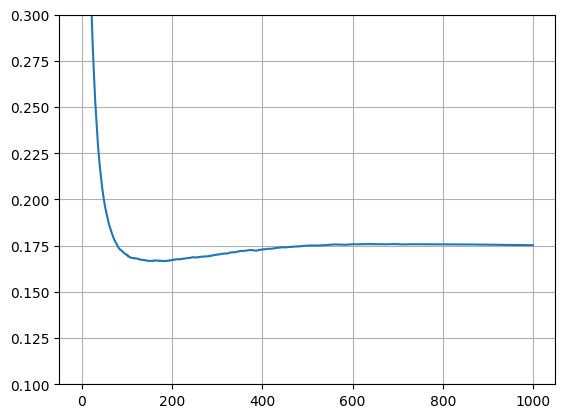

In [15]:
if MANUAL_FIND_HYPERPARAMETERS:
    best_iter = scores['test-Logloss-mean'].argmin()
    print(best_iter)
    print(scores.at[best_iter, 'test-Logloss-mean'])
    print(f"{scores.at[best_iter, 'test-Logloss-std']:.1e}")
    scores['test-Logloss-mean'].plot(ylim=[0.1, 0.3], grid=True);

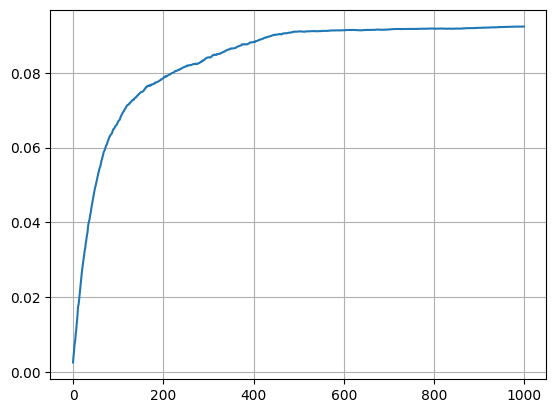

In [16]:
if MANUAL_FIND_HYPERPARAMETERS:
    scores['test-Logloss-std'].plot(grid=True);

# Auto search hyperparameters

In [18]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_loguniform('lr', 0.001, 1.0),
        'depth': trial.suggest_int('depth', 3, 14),
        'l2_leaf_reg': trial.suggest_uniform('l2_leaf_reg', 0.1, 10.0),
        'leaf_estimation_iterations': trial.suggest_int('leaf_est_it', 1, 10),
        'bagging_temperature': trial.suggest_uniform('bagging_temp', 0.0, 1.0),

        'iterations': 1000,
        'early_stopping_rounds': 100,
        'od_pval': 0.001,

        'loss_function': 'Logloss',
        'verbose': False,
        'task_type': 'GPU',
    }

    # Cross validation
    train_pool = cb.Pool(X, y['is_hallucination'])
    scores = cb.cv(
        train_pool,
        params,
        fold_count=3,
        plot=False,
        seed=RANDOM_SEED,
        shuffle=True,
        stratified=True,
        as_pandas=True,
    )
    logloss = scores['test-Logloss-mean'].min()

    return logloss


best_params = {}
if AUTO_FIND_HYPERPARAMETERS:
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=100)

    print("Best trial:", study.best_trial.number)
    print("Best metric:", study.best_trial.value)
    print("Best hyperparameters:", study.best_params)

    best_params = study.best_params
else:
    best_params = {'lr': 0.01740375272833612, 'depth': 4, 'l2_leaf_reg': 0.4989834106858575, 'leaf_est_it': 7, 'bagging_temp': 0.8178179786826862}
    

In [19]:
print("Best hyperparameters:", best_params)

Best hyperparameters: {'lr': 0.01740375272833612, 'depth': 4, 'l2_leaf_reg': 0.4989834106858575, 'leaf_est_it': 7, 'bagging_temp': 0.8178179786826862}


## Evaluate on validation sample

In [20]:
if EVALUATE_ON_VAL:
    params = {
        'learning_rate': 0.01740375272833612,
        'depth': 4,
        'l2_leaf_reg': 0.4989834106858575,
        'leaf_estimation_iterations': 7,
        'bagging_temperature': 0.8178179786826862,

        'iterations': 200,
        'loss_function': 'Logloss',
        'verbose': False,
        'task_type': 'GPU',
    }

    cv = RepeatedStratifiedKFold(n_splits=20, n_repeats=5, random_state=RANDOM_SEED)
    model = cb.CatBoostClassifier(**params)
    accuracy = []
    for i, (train_index, test_index) in enumerate(cv.split(X, y['is_hallucination'])):
        # Train
        X_train = X.loc[train_index]
        y_train = y.loc[train_index, 'is_hallucination']
        model.fit(X_train, y_train)

        # Predict
        X_test = X.loc[test_index]
        y_test = y.loc[test_index, 'is_hallucination']
        y_pred = model.predict(X_test)

        # Calc metric
        accuracy.append(accuracy_score(y_test, y_pred))
        
    # Calc average metric
    mean_accuracy = statistics.fmean(accuracy)
    print('Accuracy:', mean_accuracy)

Accuracy: 0.9438134978229319


## Train on 100 % of data

In [5]:
params = {
    'learning_rate': 0.01740375272833612,
    'depth': 4,
    'l2_leaf_reg': 0.4989834106858575,
    'leaf_estimation_iterations': 7,
    'bagging_temperature': 0.8178179786826862,

    'iterations': 200,
    'loss_function': 'Logloss',
    'verbose': False,
    'task_type': 'GPU',
}

model = cb.CatBoostClassifier(**params)
model.fit(X, y['is_hallucination'], plot=False);

## Save model

In [6]:
METAMODEL_PATH.mkdir(parents=True, exist_ok=True)
model.save_model(METAMODEL_PATH / 'metamodel.cbm')

## Load model

In [7]:
model = cb.CatBoostClassifier()
model.load_model(METAMODEL_PATH / 'metamodel.cbm');

## Predict training sample

In [10]:
pred_labels = model.predict(X)
pred_labels

array([1, 0, 1, ..., 1, 1, 0])

# Feature importance

In [11]:
display(pd.DataFrame({
    'feature_importance': model.get_feature_importance(), 
    'feature_names': X.columns,
}).sort_values(by=['feature_importance'], ascending=False))

,feature_importance,feature_names
6,22.704250,p(Entl)_ivankud-deberta-v3-large-tasksource-nli
5,14.949132,p(Contr)_ivankud-deberta-v3-large-tasksource-nli
8,10.737872,p(Entl)_ivankud-DeBERTa-v3-large-mnli-fever-an...
7,10.262242,p(Contr)_ivankud-DeBERTa-v3-large-mnli-fever-a...
4,9.519372,p(Entl)_ivankud-deberta-v2-xlarge-mnli
2,9.281647,a_len
3,7.680024,p(Contr)_ivankud-deberta-v2-xlarge-mnli
0,7.627595,s_len
1,7.237867,q_len
